## MACHINE LEARNING



## $1) \textit{Problem Definition and Main Goal} $
#### By leveraging the power of historical customer data our main goal is to create a machine learning model to predict whether an applicant is a "good" or "bad" client. That said, this problem is a supervised binary classification problem.

#### $ \textit{Main challenges} $


1.1 Unlike other tasks, no definition of "good" or "bad" is provided. As a matter of fact, our target variable (STATUS) is encoded: 

    - C: paid off that month 

    - X: No loan for the month

    - 0: 1-29 days past due 
    
    - 1: 30-59 days past due 

    - 2: 60-89 days overdue

    - 3: 90-119 days overdue

    - 4: 120-149 days overdue
    
    - 5: Overdue or bad debts
         
We have to change the encoding to binary (Good client/ bad client).


1.2 Imbalanced data is the main challenge. As We will see in more detail, data are highly imbalanced, and methods like undersampling / oversampling must be employed, to resolve these issues.


## $2) \textit{import packages, load data, create target variable} $
As mentioned earlier, this dataset lacks the definition of good/bad client. It contains historical data of customers based on credit (credit record), as well as personal data of applicants (application record). Credit record is inherited in each applicant based on ID. That means that there are Beneficiaries (duplicate ID) that will be evaluated on the same record (referenced credit record). 

In [497]:
import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns',None)

# with this import we "ignore" the warnings
import warnings
warnings.filterwarnings('ignore')

# imports for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
import sweetviz as sv
from sklearn.metrics import mutual_info_score

from collections import Counter
from imblearn.over_sampling import ADASYN

# imports for ROC / AUC /PRC Plots
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

#imports for model selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score,recall_score,f1_score, make_scorer


pd.pandas.set_option('display.max_columns',None)

### 2.2 Load data, initial exploration

In [498]:
application_status = pd.read_csv('application_record.csv')
credit_status = pd.read_csv('credit_record.csv')

In [499]:
print(f"Application_record dataset has {len(application_status)} instances and {len(application_status.columns)} Features.")
print(f"Credit_record dataset has {len(credit_status)} instances and {len(credit_status.columns)} Features.")

Application_record dataset has 438557 instances and 18 Features.
Credit_record dataset has 1048575 instances and 3 Features.


### 2.3 Create the target variable 

#### Introduction
In this subsection we are going to encode the target variable to binary, which is not a trivial procedure. According to credit data, if a customer is 60 days past due or more, at least one time in his credit history, is going to be labeled as 'bad client'. In summary we are going to add two new columns in application record.

- Account age (months of historic records)

- Status ( a new column {0: good client, 1: bad client})

1st step -> Begin month, Account age

In [500]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account_age'})
application_status=pd.merge(application_status,begin_month,how='left',on='ID')

2nd step -> Create a new variable in credit record (dep_value), setting yes if  'days overdue' in status

In [501]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'

3rd step -> Group by ID using count as aggregate

(Counts only 'Yes', not None )

if 'Yes' from last step appeared at least one time (i.e customer was at least one time 60 days overdue or more), set 'Yes', else 'No'

In [502]:
count_df=credit_status.groupby('ID').count()
count_df['dep_value'][count_df['dep_value'] > 0]='Yes'
count_df['dep_value'][count_df['dep_value'] == 0]='No'
count_df = count_df[['dep_value']]

final step -> Merge final status with application record
map: 'Yes' to 1, 'No' to 0 

In [503]:
data = pd.merge(application_status,count_df,how='inner',on='ID')
data['STATUS_FINAL']=data['dep_value']
data.loc[data['STATUS_FINAL']=='Yes','STATUS_FINAL']=1
data.loc[data['STATUS_FINAL']=='No','STATUS_FINAL']=0
data.drop('dep_value',axis=1,inplace=True)

print(f"The merged dataset has {len(data)} instances and {len(data.columns)} Features.")
print(f"Common ids (unique) betwween the two datasets are: {len(set(application_status['ID']).intersection(set(credit_status['ID'])))}")

The merged dataset has 36457 instances and 20 Features.
Common ids (unique) betwween the two datasets are: 36457


## $ 3) \textit{Exploratory Analysis} $

### 3.1 Missing and duplicate values. 


In [504]:
# search for missing values

colnames=data.columns
df=pd.DataFrame(columns=["Column","NumOfMissingVal","UniqueVal", "Type"])
for cn in colnames:
    df=df.append({"Column" : cn,
                "NumOfMissingVal": sum(pd.isna(data[cn])),
                "UniqueVal":len(data[cn].unique()),
                "Type" : data[cn].dtypes},
               ignore_index=True)

df

,Column,NumOfMissingVal,UniqueVal,Type
0,ID,0,36457,int64
1,CODE_GENDER,0,2,object
2,FLAG_OWN_CAR,0,2,object
3,FLAG_OWN_REALTY,0,2,object
4,CNT_CHILDREN,0,9,int64
5,AMT_INCOME_TOTAL,0,265,float64
6,NAME_INCOME_TYPE,0,5,object
7,NAME_EDUCATION_TYPE,0,5,object
8,NAME_FAMILY_STATUS,0,5,object
9,NAME_HOUSING_TYPE,0,6,object


<AxesSubplot: >

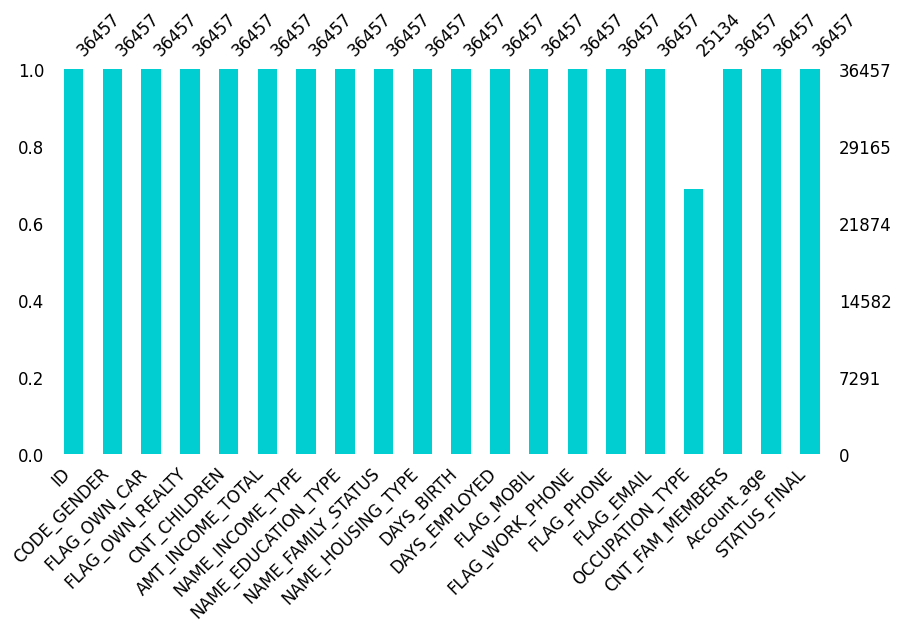

In [505]:
# plot the attributes to identify the ones with missing values

msno.bar(data, figsize = (10,5), fontsize = 12, color = "darkturquoise")

In [506]:
# search for duplicate values

data.duplicated().sum()

0

In [507]:
# drop this attribute as it has just one unique value

data.drop(['FLAG_MOBIL'], inplace = True, axis = 1)

<AxesSubplot: >

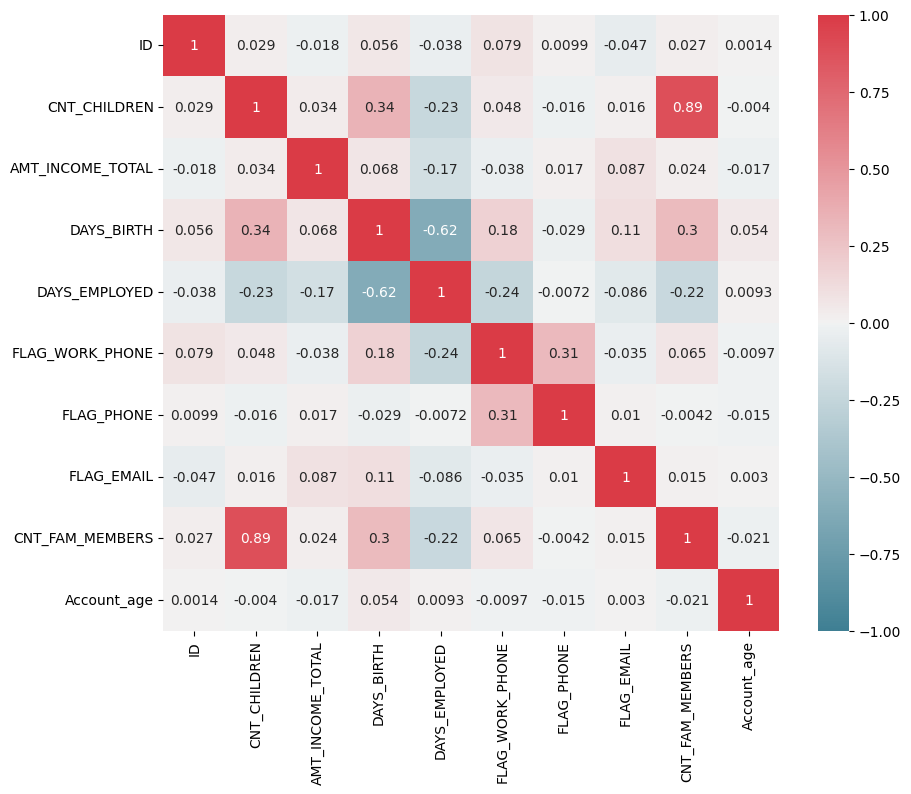

In [508]:
# plot the correlation matrix to identify the correlations between attributes

f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method='pearson')
sns.heatmap(corr, annot=True,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

- OCCUPATION_TYPE column has 11323 null values, 31 % of the dataset.
- no duplicate values are observed
- no correlation observed (except from CNT_FAM_MEMBERS & CNT_CHILDREN for obvious reasons)

### 3.2 Target variable

In [509]:
#Rename target variable
data = data.rename(columns={'STATUS_FINAL': 'target'})
print("############")
print('Percentages')
print("############")
print(round(data['target'].value_counts(normalize=True), 2))

############
Percentages
############
0    0.98
1    0.02
Name: target, dtype: float64


0    35841
1      616
Name: target, dtype: int64


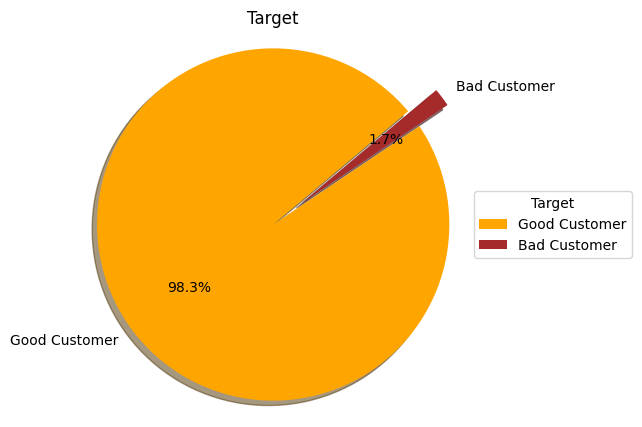

In [510]:
# plot the target variable 
print(data['target'].value_counts())

plt.figure(figsize=(5,5))
e = (0.2,0)
colors = ("orange", "brown")
label = ['Good Customer','Bad Customer']

plt.pie(data['target'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=40)

plt.axis('equal')
plt.title('Target')
plt.legend(title = "Target",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))


- According to the above plot, high imbalance observed in target variable as 98.3% of customers are considered "Good" and just 1.7% are considered "Bad"

### 3.3 Attributes

In [511]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df


def get_category(df, col, binsnum, labels, qcut = False):


    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df


def mutual_information(dataframe, columns):
    """
    This function returns the mutual information between the specified columns in the dataframe
    :param dataframe: pandas dataframe
    :param columns: list of columns for which mutual information is to be calculated
    :return: mutual information
    """
    mutual_information_table = pd.DataFrame(columns=['feature1', 'feature2', 'mutual_info'])
    for column1 in columns:
        for column2 in columns:
            if column1 != column2:
                mutual_info = mutual_info_score(dataframe[column1], dataframe[column2])
                mutual_information_table = mutual_information_table.append({'feature1': column1, 
                                                                            'feature2': column2, 
                                                                            'mutual_info': mutual_info}, 
                                                                           ignore_index=True)
    return mutual_information_table

- Drop Email, phone, work phone which are provide no information for our problem
- Drop CNT_FAM_MEMBERS because it is reduntant
- set ID as index


In [512]:
data.drop(['FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS'], inplace = True, axis = 1)

data.set_index('ID', drop = True, inplace = True)

In [513]:
data.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,Account_age,target
ID,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,NaN,-15.0,0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,NaN,-14.0,0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,-29.0,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,-4.0,0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,-26.0,0


#### Binary

Gender (CODE_GENDER)

In [514]:
#Rename column
data = data.rename(columns={'CODE_GENDER': 'gender'})
# map values to binary 
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print(data['gender'].value_counts())

0    24430
1    12027
Name: gender, dtype: int64


0    24430
1    12027
Name: gender, dtype: int64


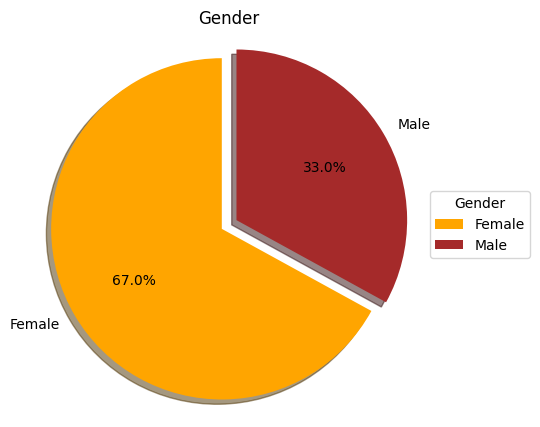

In [515]:
# plot the Gender Distribution  
print(data['gender'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1,0)
colors = ( "orange", "brown")
label = ['Female','Male']

plt.pie(data['gender'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Gender')
plt.legend(title = "Gender",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))


In [516]:
print(mutual_information(data, ['target', 'gender']))

  feature1 feature2  mutual_info
0   target   gender     0.000114
1   gender   target     0.000114


has a car (FLAG_OWN_CAR)

In [517]:
#Rename column
data = data.rename(columns={'FLAG_OWN_CAR': 'car'})
# map values to binary 
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())

0    22614
1    13843
Name: car, dtype: int64


0    22614
1    13843
Name: car, dtype: int64


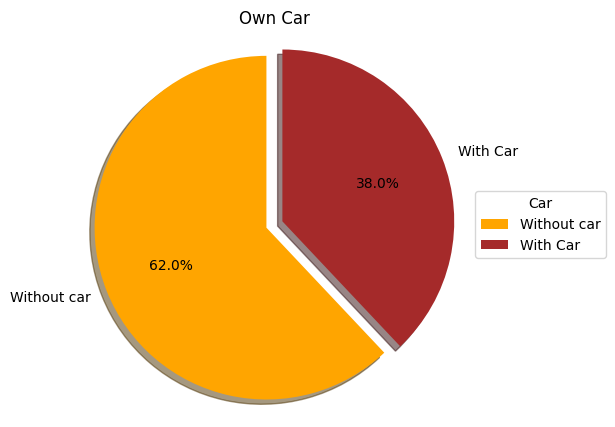

In [518]:
# plot the distribution of customers with / without car

print(data['car'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1,0)
colors = ( "orange", "brown")
label = ['Without car','With Car']

plt.pie(data['car'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Own Car')
plt.legend(title = "Car",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))


In [519]:
print(mutual_information(data, ['target', 'car']))

  feature1 feature2  mutual_info
0   target      car     0.000009
1      car   target     0.000009


Owns property (FLAG_OWN_REALTY)

In [520]:
#Rename column
data = data.rename(columns={'FLAG_OWN_REALTY': 'property'})
# map values to binary 
data['property'] = data['property'].replace(['N','Y'],[0,1])
print(data['property'].value_counts())

1    24506
0    11951
Name: property, dtype: int64


1    24506
0    11951
Name: property, dtype: int64


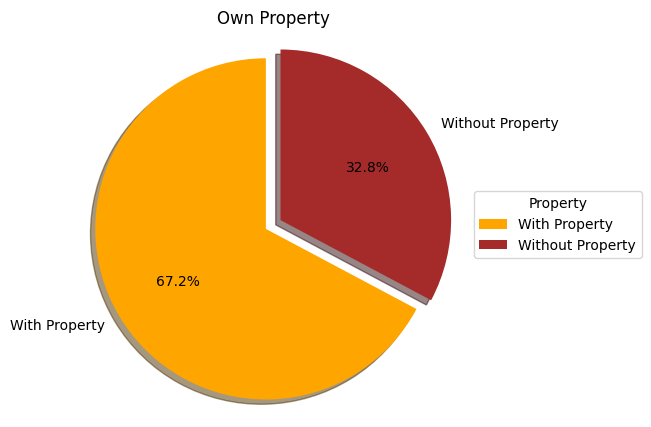

In [521]:
# plot the distribution of customers with / without property

print(data['property'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1,0)
colors = ( "orange", "brown")
label = ['With Property','Without Property']

plt.pie(data['property'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
plt.title('Own Property')
plt.legend(title = "Property",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))

In [522]:
print(mutual_information(data, ['target', 'property']))

   feature1  feature2  mutual_info
0    target  property     0.000239
1  property    target     0.000239


### Discrete

Calculate age, make bins 

In [523]:
data = data.rename(columns={'AGE': 'age'})
data['age']=-(data['DAYS_BIRTH'])//365
data.drop(columns=('DAYS_BIRTH'), inplace=True)

<AxesSubplot: title={'center': 'Age Distribution'}, ylabel='Frequency'>

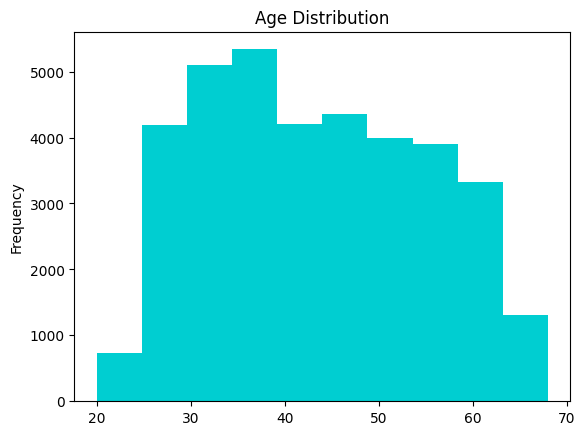

In [524]:
# plot the distribution of age

data['age'].plot(kind='hist', color="darkturquoise", grid=False, title='Age Distribution')

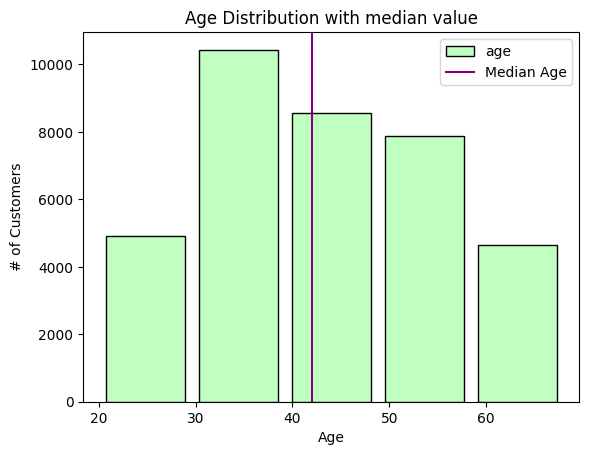

In [525]:
# plot the distribution of age and display the median age which is at 42 years

data['age'].plot(kind='hist',bins=5, color='#C1FFC1', 
                 rwidth=0.85, edgecolor='black', title='Age Distribution with median value', histtype='bar')

median = data['age'].median()
plt.axvline(median, color='purple', label="Median Age")
plt.xlabel("Age")
plt.ylabel("# of Customers")
plt.legend()
plt.show()


In [526]:
data['age'].describe()

count    36457.000000
mean        43.260334
std         11.510414
min         20.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: age, dtype: float64

In [527]:
data['age'] = data['age'].astype(int)

In [528]:
data['age'].value_counts(bins=5,normalize=True,sort=False)

(19.951, 29.6]    0.135173
(29.6, 39.2]      0.286255
(39.2, 48.8]      0.234962
(48.8, 58.4]      0.216392
(58.4, 68.0]      0.127218
Name: age, dtype: float64

<AxesSubplot: title={'center': 'Age group density plot'}, ylabel='Frequency'>

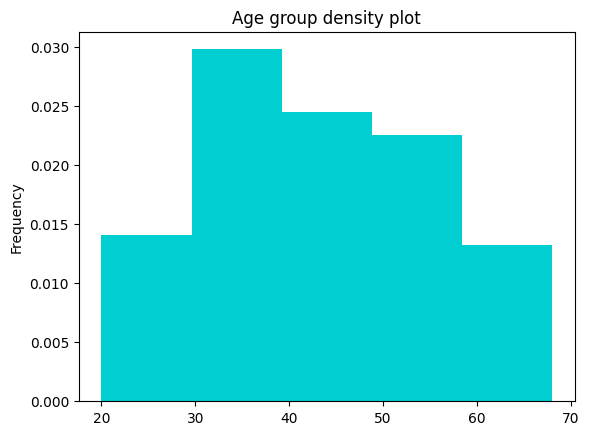

In [529]:
# plot the density of age groups

data['age'].plot(kind='hist',bins=5,density=True, color="darkturquoise", title='Age group density plot')

In [530]:
data = get_category(data,'age',5, ["[19-29)","[29-39)","[39-49)","[49-59)","[59-69)"])

In [531]:
data[['age', 'gp_age']].head(10)

,age,gp_age
ID,,
5008804,32,[29-39)
5008805,32,[29-39)
5008806,58,[49-59)
5008808,52,[49-59)
5008809,52,[49-59)
5008810,52,[49-59)
5008811,52,[49-59)
5008812,61,[59-69)
5008813,61,[59-69)


In [532]:
#mapping the age groups

data['age_enc'] = data['gp_age']
data['age_enc']  = data['age_enc'].map({"[19-29)":0,"[29-39)":1, "[39-49)":2, "[49-59)":3, "[59-69)":4})
data['age_enc'].value_counts()

1    10436
2     8566
3     7889
0     4928
4     4638
Name: age_enc, dtype: int64

In [533]:
data.columns

Index(['gender', 'car', 'property', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'Account_age',
       'target', 'age', 'gp_age', 'age_enc'],
      dtype='object')

1    10436
2     8566
3     7889
0     4928
4     4638
Name: age_enc, dtype: int64


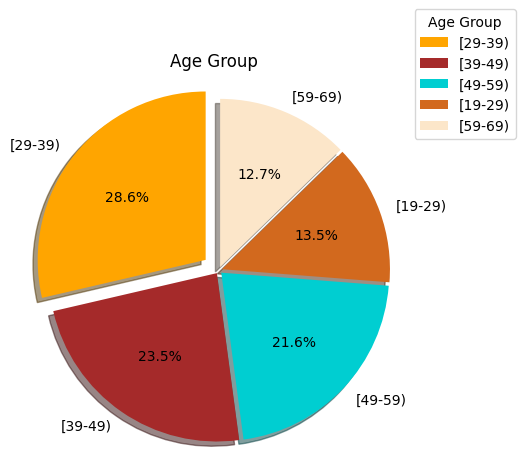

In [534]:
# plot the age groups

print(data['age_enc'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1,0.02,0.02,0.02,0.02)
colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9")
label = ["[29-39)","[39-49)","[49-59)","[19-29)","[59-69)"]

plt.pie(data['age_enc'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Age Group')
plt.legend(title = "Age Group",
          loc = "center left",
          bbox_to_anchor = (1, 0.5,1,1))

In [535]:
print(mutual_information(data, ['target', 'age_enc']))

  feature1 feature2  mutual_info
0   target  age_enc     0.000075
1  age_enc   target     0.000075


number of children (CNT_CHILDREN)

In [536]:
data = data.rename(columns={'CNT_CHILDREN': 'nr_children'})


In [537]:
data.columns

Index(['gender', 'car', 'property', 'nr_children', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'Account_age',
       'target', 'age', 'gp_age', 'age_enc'],
      dtype='object')

In [538]:
data['nr_children'] = data['nr_children'].astype(int) 

In [539]:
data['nr_children'].value_counts()

0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: nr_children, dtype: int64

0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: nr_children, dtype: int64


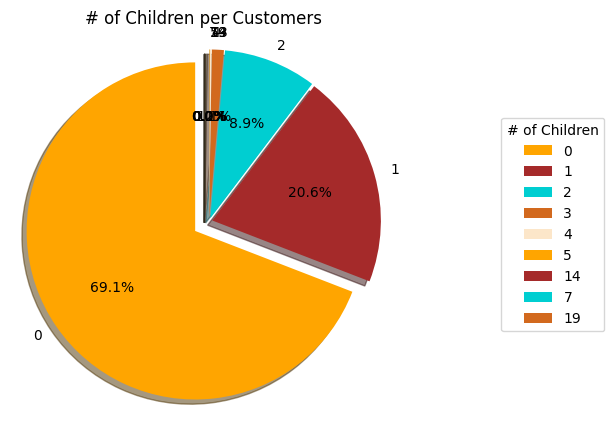

In [540]:
# plot the number of Children per Customer

print(data['nr_children'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02)
colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9")
label = ['0','1','2','3','4', '5', '14', '7', '19']


plt.pie(data['nr_children'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('# of Children per Customers')
plt.legend(title = "# of Children",
          loc = "center left",
          bbox_to_anchor = (1.25, 0.5,1.25,0))

- According to the above plot, customers with greater than 3 Children are few comparing with the ones with 0-2 Children that's why we decided to group the customers with 3-19 Children

In [541]:
# group the number of Children

data['famsize'] = None
data.loc[data['nr_children']>=3, 'famsize'] = '>=3'
data.loc[data['nr_children']==2, 'famsize'] = '2'
data.loc[data['nr_children']==1, 'famsize'] = '1'
data.loc[data['nr_children']==0, 'famsize'] = '0'


In [542]:
data['famsize'].value_counts()

0      25201
1       7492
2       3256
>=3      508
Name: famsize, dtype: int64

In [543]:
#mapping the family size

data.famsize = data.famsize.map({"0":0,"1":1,'2':2,">=3":3})

0    25201
1     7492
2     3256
3      508
Name: famsize, dtype: int64


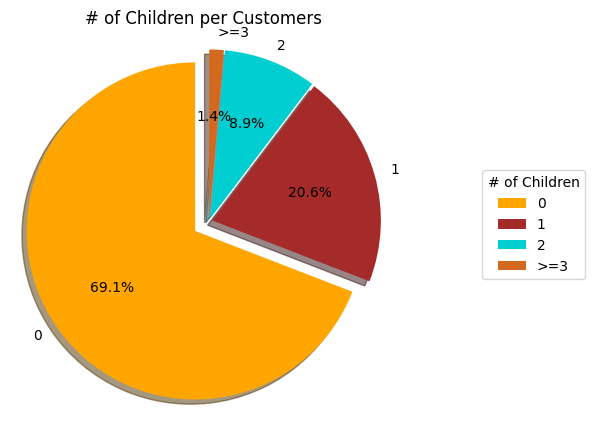

In [544]:
# plot the distribution of Customer's Children

print(data['famsize'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1, 0.02, 0.02, 0.02)
colors = ( "orange", "brown", "darkturquoise", "chocolate")
label = ['0','1','2','>=3']


plt.pie(data['famsize'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('# of Children per Customers')
plt.legend(title = "# of Children",
          loc = "center left",
          bbox_to_anchor = (1.2, 0.5,0.5,0))


Income (AMT_INCOME_TOTAL)

In [545]:
data = data.rename(columns={'AMT_INCOME_TOTAL': 'income'})

In [546]:
data['income']

ID
5008804    427500.0
5008805    427500.0
5008806    112500.0
5008808    270000.0
5008809    270000.0
             ...   
5149828    315000.0
5149834    157500.0
5149838    157500.0
5150049    283500.0
5150337    112500.0
Name: income, Length: 36457, dtype: float64

In [547]:
data['income'].describe()

count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: income, dtype: float64

In [548]:
# We decided to divide the income by 100.000 (100K) so as to avoid scaling issues between instances

data.income = data.income/100000
data.income = data.income.astype('int')


In [549]:
data['income']

ID
5008804    4
5008805    4
5008806    1
5008808    2
5008809    2
          ..
5149828    3
5149834    1
5149838    1
5150049    2
5150337    1
Name: income, Length: 36457, dtype: int32

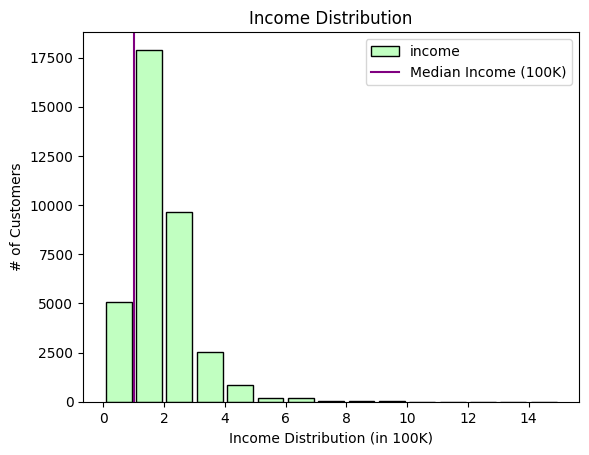

In [550]:
# plot the distribution of income in 100 thousands(100K)

data['income'].plot(kind='hist',bins=15, color='#C1FFC1', 
                 rwidth=0.85, edgecolor='black', title='Income Distribution')

median = data['income'].median()
plt.axvline(median, color='purple', label="Median Income (100K)")
plt.xlabel("Income Distribution (in 100K)")
plt.ylabel("# of Customers")
plt.legend()
plt.show()


In [551]:
data['income'].describe()

count    36457.000000
mean         1.401542
std          1.069312
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: income, dtype: float64

In [552]:
round(data['income'].value_counts(bins = 5, normalize=True), 2)

(-0.016, 3.0]    0.96
(3.0, 6.0]       0.03
(6.0, 9.0]       0.00
(12.0, 15.0]     0.00
(9.0, 12.0]      0.00
Name: income, dtype: float64

<AxesSubplot: >

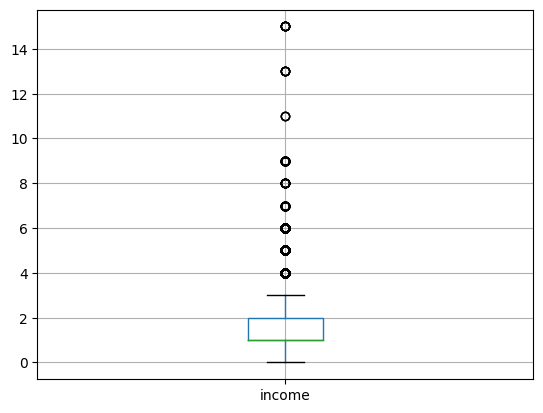

In [553]:
data.boxplot(column='income')

In [554]:
# We decided to keep those customers who have income <95 as there is no bad customer with income>=95

data[(data['income'] > 9) & (data['target'] == 1)][['income', 'target']]

,income,target
ID,,


In [555]:
data = data[(data['income'] <= 9.0)]
len(data)

36440

<AxesSubplot: >

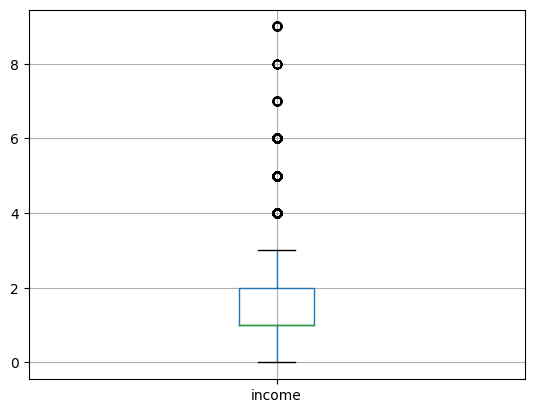

In [556]:
data.boxplot(column='income')

NAME_INCOME_TYPE

In [557]:
data = data.rename(columns={'NAME_INCOME_TYPE': 'income_type'})
data['income_type'].value_counts()

Working                 18818
Commercial associate     8474
Pensioner                6152
State servant            2985
Student                    11
Name: income_type, dtype: int64

<AxesSubplot: title={'center': 'Distribution of Income types'}>

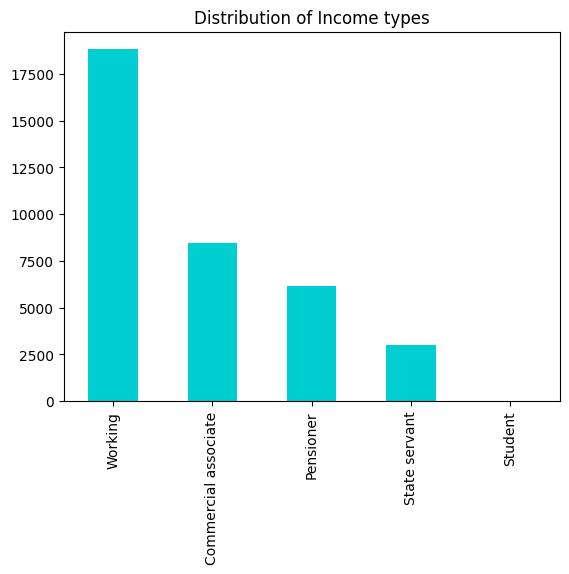

In [558]:
# plot the distribution of income types

data['income_type'].value_counts().plot(kind='bar', grid=False, color="darkturquoise", title='Distribution of Income types')

In [559]:
#mapping the income type

data.income_type = data.income_type.map({"Working":0,"Commercial associate":1,
                                         "State servant":2, "Student":3, "Pensioner":4})

0    18818
1     8474
4     6152
2     2985
3       11
Name: income_type, dtype: int64


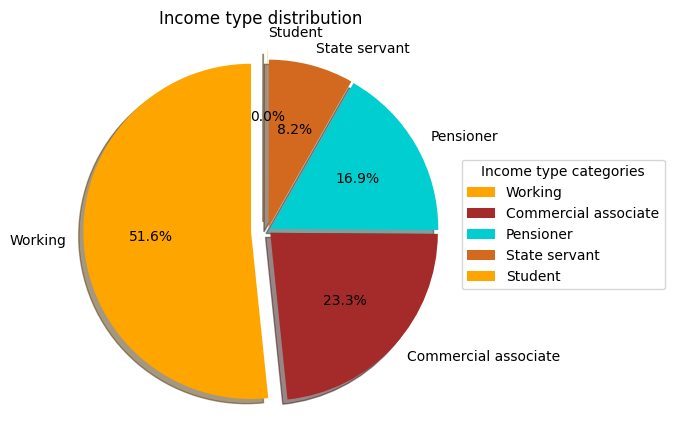

In [560]:
# plot the income type distribution after mapping

print(data['income_type'].value_counts())

plt.figure(figsize=(5,5))
e = (0.1, 0.02, 0.02, 0.02, 0.08)
colors = ( "orange", "brown", "darkturquoise", "chocolate")
label = ['Working','Commercial associate','Pensioner','State servant','Student']


plt.pie(data['income_type'].value_counts(), colors = colors, 
        labels = label, explode = e, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Income type distribution')
plt.legend(title = "Income type categories",
          loc = "center left",
          bbox_to_anchor = (1, 0.5,1,0))


Education type (NAME_EDUCATION_TYPE)

In [561]:
data = data.rename(columns={'NAME_EDUCATION_TYPE': 'education'})
data['education'].value_counts()


Secondary / secondary special    24776
Higher education                  9848
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: education, dtype: int64

In [562]:
#mapping the education

data.education = data.education.map({"Lower secondary":0,"Secondary / secondary special":1,
                                     'Incomplete higher':2,"Higher education":3,  "Academic degree":4})

1    24776
3     9848
2     1410
0      374
4       32
Name: education, dtype: int64


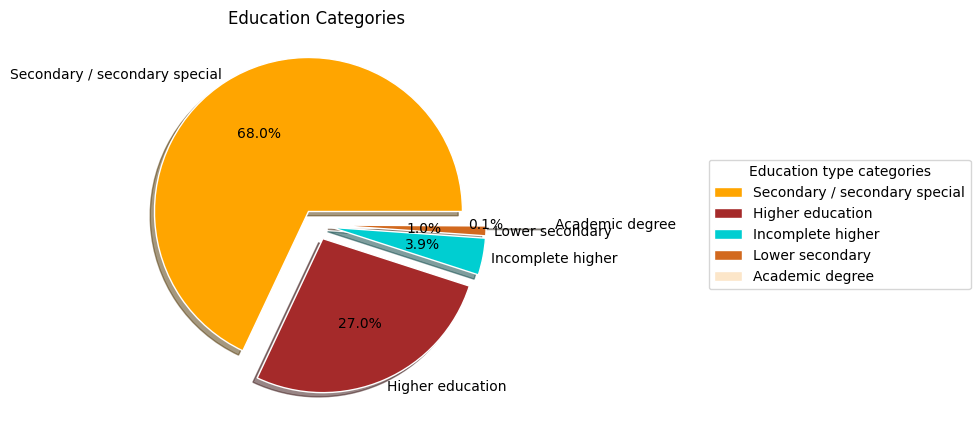

In [563]:
# plot the distribution of Customer's education

print(data['education'].value_counts())

colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9")
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
e = (0.1, 0.1, 0.1, 0.1, 0.5)
labels= ['Secondary / secondary special',
         'Higher education','Incomplete higher','Lower secondary','Academic degree']
pie_wedge_collection = ax.pie(data['education'].value_counts(),  explode = e, colors=colors, labels=labels, 
                              labeldistance=1.05, pctdistance=0.6, autopct='%1.1f%%', shadow=True);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Education Categories")
ax.legend(title = "Education type categories",
           loc = "center left", bbox_to_anchor = (1.5, 0.5,1,0))


In [564]:
data.columns

Index(['gender', 'car', 'property', 'nr_children', 'income', 'income_type',
       'education', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED',
       'OCCUPATION_TYPE', 'Account_age', 'target', 'age', 'gp_age', 'age_enc',
       'famsize'],
      dtype='object')

Family Status (NAME_FAMILY_STATUS)

In [565]:
data = data.rename(columns={'NAME_FAMILY_STATUS': 'marriage_status'})

In [566]:
data['marriage_status'].value_counts()

Married                 25039
Single / not married     4821
Civil marriage           2945
Separated                2103
Widow                    1532
Name: marriage_status, dtype: int64

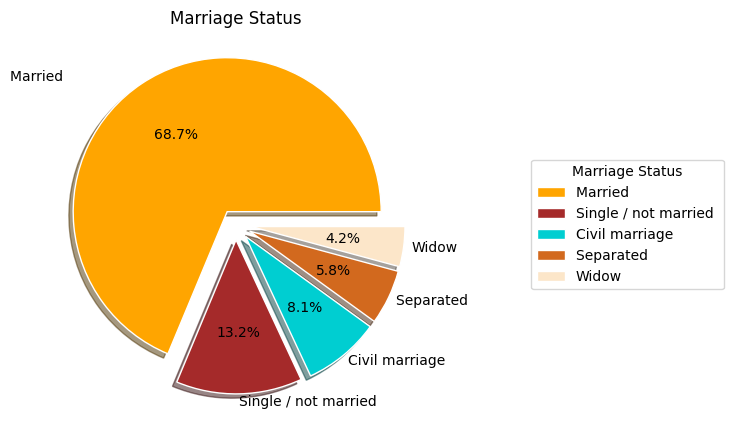

In [567]:
# plot the distribution of marriage_status

colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9")
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
e = (0.1, 0.1, 0.1, 0.1, 0.1)
labels= ['Married                 ',
         'Single / not married ','Civil marriage ','Separated  ','Widow']

pie_wedge_collection = ax.pie(data['marriage_status'].value_counts(),  explode = e, colors=colors, labels=labels, 
                              labeldistance=1.05, pctdistance=0.6, autopct='%1.1f%%', shadow=True);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Marriage Status")
ax.legend(title = "Marriage Status",
           loc = "center left", bbox_to_anchor = (1.25, 0.5,1,0))


In [568]:
#mapping the marriage_status

data.marriage_status = data.marriage_status.map({"Married":1,"Single / not married":0, 
                                                 "Civil marriage":1, "Separated":0, "Widow":0})

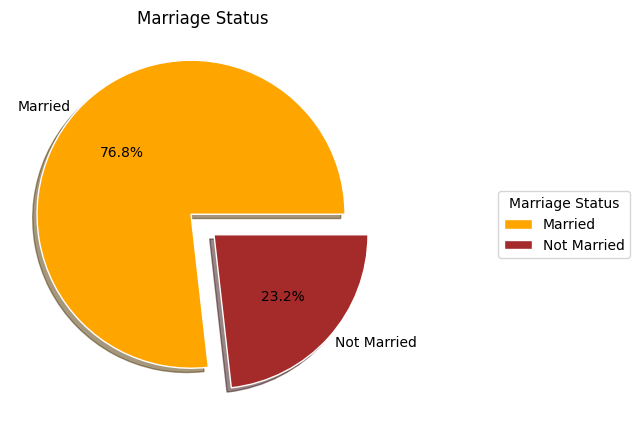

In [569]:
# plot the marriage_status after mapping

colors = ( "orange", "brown")
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
e = (0.1, 0.1)
labels= ['Married','Not Married']

pie_wedge_collection = ax.pie(data['marriage_status'].value_counts(),  explode = e, colors=colors, labels=labels, 
                              labeldistance=1.05, pctdistance=0.6, autopct='%1.1f%%', shadow=True);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Marriage Status")
ax.legend(title = "Marriage Status",
           loc = "center left", bbox_to_anchor = (1.25, 0.5,1,0))


Housing_type ('NAME_HOUSING_TYPE')

In [570]:
data = data.rename(columns={'NAME_HOUSING_TYPE': 'housing_type'})

In [571]:
data['housing_type'].value_counts()

House / apartment      32538
With parents            1776
Municipal apartment     1122
Rented apartment         574
Office apartment         262
Co-op apartment          168
Name: housing_type, dtype: int64

In [572]:
#mapping the housing type
data.housing_type = data.housing_type.map({"House / apartment":0,"Rented apartment":1, 
                                           "Municipal apartment":2, "With parents":3,
                                           "Co-op apartment":4, "Office apartment":5})

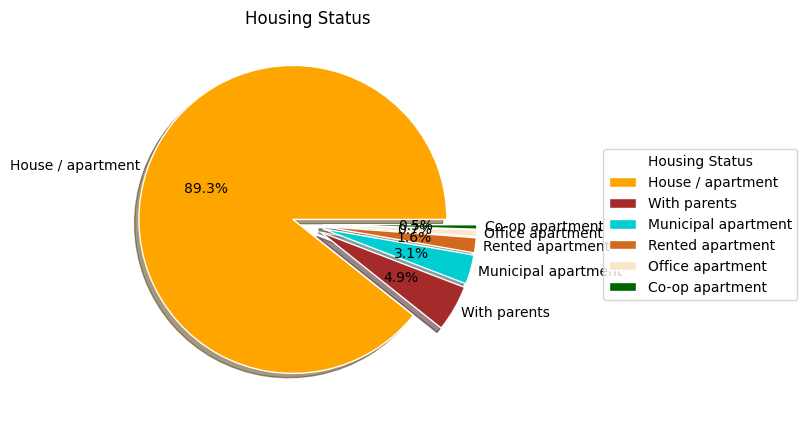

In [573]:
# plot the distribution of housing types

colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9", 'darkgreen')
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
e = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
labels= ['House / apartment',
         'With parents','Municipal apartment','Rented apartment','Office apartment','Co-op apartment']

pie_wedge_collection = ax.pie(data['housing_type'].value_counts(),  explode = e, colors=colors, labels=labels, 
                              labeldistance=1.05, pctdistance=0.6, autopct='%1.1f%%', shadow=True);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Housing Status")
ax.legend(title = "Housing Status",
           loc = "center left", bbox_to_anchor = (1.25, 0.5,1,0))


days employed (DAYS_EMPLOYED)

In [574]:
def get_years_employed(days_employed):
    # returns 0 if unemployed
    return 0 if days_employed>0 else -(days_employed)//365


data = data.rename(columns={'DAYS_EMPLOYED': 'days_employed'})

In [575]:
data['years_employed']= data['days_employed'].apply(lambda x: get_years_employed(x))
data.drop(columns=('days_employed'), inplace=True)

In [576]:
data['years_employed'].describe()

count    36440.000000
mean         5.614791
std          6.418473
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         43.000000
Name: years_employed, dtype: float64

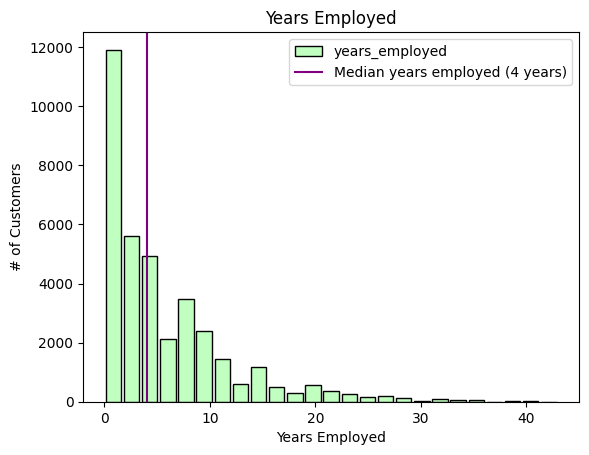

In [577]:
# plot the customer's empployed years
data['years_employed'].plot(kind='hist',bins=25, color='#C1FFC1', 
                 rwidth=0.85, edgecolor='black', title='Years Employed')

median = data['years_employed'].median()
plt.axvline(median, color='purple', label="Median years employed (4 years)")
plt.xlabel("Years Employed")
plt.ylabel("# of Customers")
plt.legend()
plt.show()


In [578]:
data['years_employed'].describe()

count    36440.000000
mean         5.614791
std          6.418473
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         43.000000
Name: years_employed, dtype: float64

Occupation type (OCCUPATION_TYPE)

In [579]:
data = data.rename(columns={'OCCUPATION_TYPE': 'occupation_type'})

In [580]:
len(data[data['occupation_type'].isna()])

11323

In [581]:
# fill the n/a values
data['occupation_type'].fillna('other/na',inplace=True)

    We transform the values in a way that:
    
        - Accountants = 0
        - Managers = 0
        - Sales staff = 0
        - IT staff = 1
        - High skill tech staff = 1
        - Security staff = 2
        - Laborers = 3
        - Drivers = 3
        - Core staff = 3
        - Cleaning staff = 3
        - Private service staff = 3
        - Low-skill Laborers = 3 
        - Medicine staff = 4
        - Cooking staff = 5
        - Waiters/barmen staff = 5
        - HR staff = 6
        - Secretaries = 6
        - Realty agents = 7   
        - other/na = 8

In [582]:
data['occupation_type'].value_counts()

other/na                 11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  2995
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: occupation_type, dtype: int64

In [583]:
#mapping the occupation_type

data.occupation_type = data.occupation_type.map({
"Accountants":0,
"Managers":0, 
"Sales staff":2, 
"IT staff":3, 
"High skill tech staff": 1,
"Security staff": 2,
"Laborers": 3,
"Drivers": 3,
"Core staff": 3,
"Cleaning staff": 3,
"Private service staff": 3,
"Low-skill Laborers": 3,
"Medicine staff": 4,
"Cooking staff": 5,
"Waiters/barmen staff": 5,
"HR staff": 6,
"Secretaries": 6,
"Realty agents": 7,
'other/na': 8})

In [584]:
data['occupation_type'].value_counts()

3    13070
8    11323
0     4236
2     4077
1     1383
4     1207
5      829
6      236
7       79
Name: occupation_type, dtype: int64

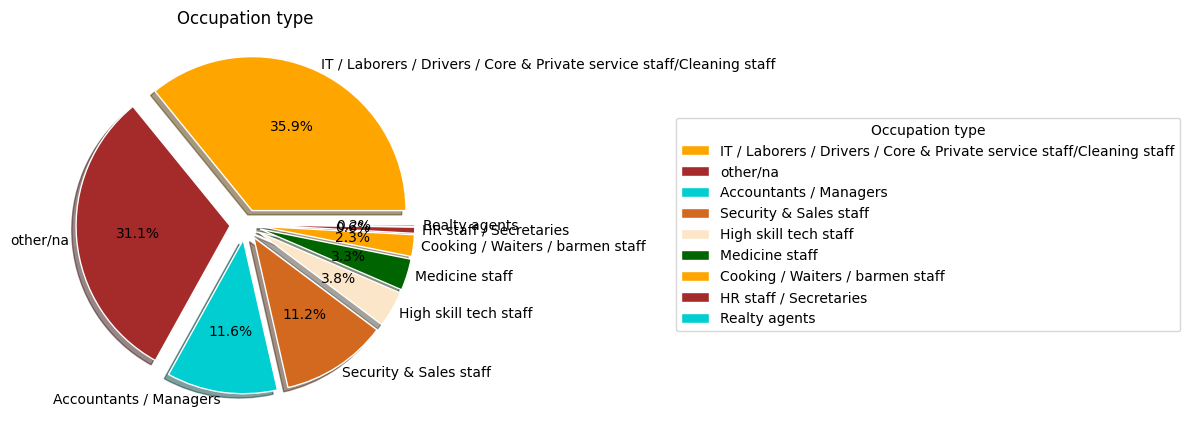

In [585]:
# plot the distribution of occupations

colors = ( "orange", "brown", "darkturquoise", "chocolate", "#FCE6C9", 'darkgreen')
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
e = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1)
labels= ['IT / Laborers / Drivers / Core & Private service staff/Cleaning staff',
         'other/na','Accountants / Managers','Security & Sales staff','High skill tech staff','Medicine staff',
         'Cooking / Waiters / barmen staff','HR staff / Secretaries','Realty agents']


pie_wedge_collection = ax.pie(data['occupation_type'].value_counts(),  explode = e, colors=colors, labels=labels, 
                              labeldistance=1.05, pctdistance=0.6, autopct='%1.1f%%', shadow=True);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Occupation type")
ax.legend(title = "Occupation type",
           loc = "center left", bbox_to_anchor = (1.6, 0.5,1,0))

### 3.4 Class Imbalance

This problem represents an imbalanced classification supervised learning problem where one class (The class of bad clients) outnumbers other class (the class of good clients) by a large proportion. More specifically the class of bad clients represents less than 2 % of the total records.

It is also worth noting that the cost of misclassification of the minority class is much higher than that of the majority class.

SMOTE (Synthetic Minority Over-sampling Technique) oversampling method can be employed to address this issue.

This method loops through every data point of the minority class, finds the k nearest neighbours, and creates new random samples, which lie in the straight lines of these neighbours.

We are going to use Adasyn (Adaptive Synthetic Sampling), a variation of the SMOTE  algorithm for handling imbalanced datasets. Like SMOTE, ADASYN generates synthetic samples of the minority class in order to balance the class distribution. However, it addresses one of the limitations of SMOTE by taking into account the degree of imbalance of the nearest neighbors for each minority sample, rather than just randomly selecting them.

In [586]:
data.columns

Index(['gender', 'car', 'property', 'nr_children', 'income', 'income_type',
       'education', 'marriage_status', 'housing_type', 'occupation_type',
       'Account_age', 'target', 'age', 'gp_age', 'age_enc', 'famsize',
       'years_employed'],
      dtype='object')

In [587]:
X = data[['gender', 'car', 'property', 'nr_children', 'income', 'income_type',
       'education', 'marriage_status', 'housing_type', 'occupation_type',
       'Account_age','age_enc', 'famsize',
       'years_employed']]
y = data['target']
print(X.shape, y.shape)

(36440, 14) (36440,)


In [588]:
X = X.astype(int).to_numpy()
y = y.astype(int).to_numpy()

In [589]:
sm = ADASYN(sampling_strategy = 0.35,random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0: 35824, 1: 616})
Resampled dataset shape Counter({0: 35824, 1: 12652})


## $ 3) \textit{Model Selection} $

There are several machine learning classification algorithms that have been specifically designed to handle imbalanced datasets. For example:

- Decision Tree-based algorithms: like RUSBoost and Cost-sensitive decision tree
- Logistic Regression: As we have seen this algorithm can be modified to handle imbalanced datasets by using cost-sensitive learning, which assigns different misclassification costs to different classes.
- Support Vector Classifiers: Support Vector Machine (SVM): SVM algorithm can handle imbalanced datasets by using different kernel functions, and adjusting parameter C.

We are going to employ a Decision Tree, configuring ’class weight’ = ’balanced’, so that weights inversely
proportional to the class sizes are used to multiply the loss function.

We also want to use cross-validation technique to evaluate the models more robustly.

In [590]:
precision = make_scorer(precision_score, greater_is_better=True,  pos_label=1)
recall = make_scorer(recall_score, greater_is_better=True,  pos_label=1)
f1 = make_scorer(f1_score, greater_is_better=True,  pos_label=1)

LogisticRegression

In [591]:
lr= LogisticRegression(solver='liblinear', class_weight = 'balanced')
scores = cross_validate(lr, X_resampled, y_resampled, cv=7, scoring={'precision':precision, 
                                                                     'recall':recall, 'f1':f1},
                                                                    verbose=1, return_train_score = True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s finished


In [592]:
print('##########')
print("T R A I N ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print('##########')
print(" T E S T ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))

##########
T R A I N 
##########
Precision: 0.48 (+/- 0.01)
Recall: 0.74 (+/- 0.01)
F1-score: 0.58 (+/- 0.01)
##########
 T E S T 
##########
Precision: 0.47 (+/- 0.05)
Recall: 0.71 (+/- 0.14)
F1-score: 0.57 (+/- 0.07)


DecisionTreeClassifier

In [593]:
clf = DecisionTreeClassifier(max_depth = 7, class_weight = 'balanced')
scores = cross_validate(clf, X_resampled, y_resampled, cv=7, scoring={'precision':precision, 
                                                                      'recall':recall, 'f1':f1}, 
                                                                    verbose=1, return_train_score = True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s finished


In [594]:
print('##########')
print("T R A I N ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print('##########')
print(" T E S T ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))


##########
T R A I N 
##########
Precision: 0.48 (+/- 0.04)
Recall: 0.85 (+/- 0.05)
F1-score: 0.61 (+/- 0.02)
##########
 T E S T 
##########
Precision: 0.45 (+/- 0.05)
Recall: 0.79 (+/- 0.14)
F1-score: 0.57 (+/- 0.07)


SVC

In [595]:
svc = SVC(kernel = 'rbf', gamma = 1e-4, C = 20, class_weight = 'balanced')

In [596]:
scores = cross_validate(svc, X_resampled, y_resampled, cv=7,n_jobs = 4, scoring={'precision':precision, 
                                                                                 'recall':recall, 'f1':f1},
                                                                                  verbose=1, return_train_score = True)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:  9.3min finished


In [597]:
print('##########')
print("T R A I N ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print('##########')
print(" T E S T ")
print('##########')
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))

##########
T R A I N 
##########
Precision: 0.49 (+/- 0.02)
Recall: 0.76 (+/- 0.01)
F1-score: 0.60 (+/- 0.01)
##########
 T E S T 
##########
Precision: 0.48 (+/- 0.05)
Recall: 0.72 (+/- 0.14)
F1-score: 0.57 (+/- 0.08)


ROC - AUC - PRC for LogisticRegression & DecisionTreeClassifier

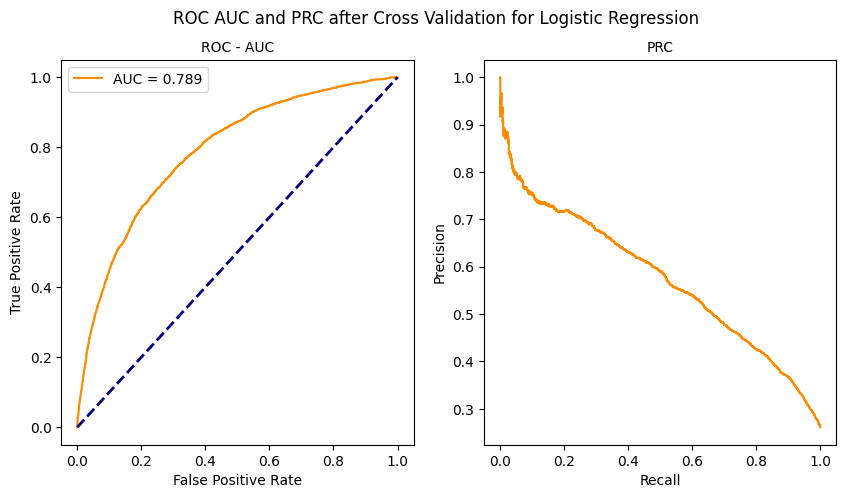

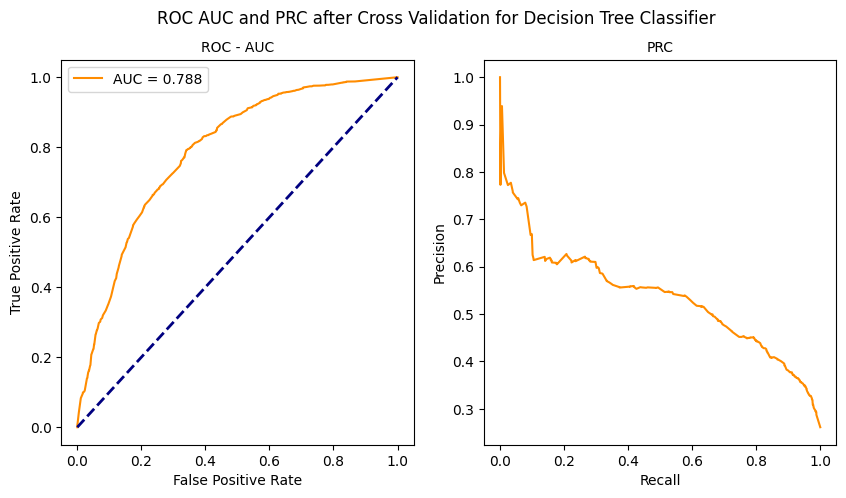

In [599]:
# Create a function to plot the ROC AUC and PRC subplots

def plot_roc_prc(model_1, model_2, X, y):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    plt.suptitle('ROC AUC and PRC after Cross Validation for Logistic Regression') #title for the 1st subplot
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,5))
    plt.suptitle('ROC AUC and PRC after Cross Validation for Decision Tree Classifier') #title for the 2nd subplot
    
    # Perform cross validation and get predicted scores
    y_scores_1 = cross_val_predict(model_1, X, y, cv=7, method='predict_proba')
    y_scores_2 = cross_val_predict(model_2, X, y, cv=7, method='predict_proba')
    
    # Compute ROC AUC and plot on first / third subplot
    fpr_1, tpr_1, thresholds_1 = roc_curve(y, y_scores_1[:, 1])
    roc_auc_1 = roc_auc_score(y, y_scores_1[:, 1])
    
    fpr_2, tpr_2, thresholds_2 = roc_curve(y, y_scores_2[:, 1])
    roc_auc_2 = roc_auc_score(y, y_scores_2[:, 1])
    
    ax1.plot(fpr_1, tpr_1, label='AUC = {:.3f}'.format(roc_auc_1), color= 'darkorange')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC - AUC', fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax1.legend()
    
    ax3.plot(fpr_2, tpr_2, label='AUC = {:.3f}'.format(roc_auc_2), color= 'darkorange')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC - AUC', fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax3.legend()
    
    # Compute PRC and plot on second / fourth subplot
    precision_1, recall_1, thresholds_1 = precision_recall_curve(y, y_scores_1[:, 1])
    ax2.plot(recall_1, precision_1,color= 'darkorange')
    ax2.set_xlabel('Recall')
    ax2.set_title('PRC', fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax2.set_ylabel('Precision')
    
    precision_2, recall_2, thresholds_2 = precision_recall_curve(y, y_scores_2[:, 1])
    ax4.plot(recall_2, precision_2,color= 'darkorange')
    ax4.set_xlabel('Recall')
    ax4.set_title('PRC', fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax4.set_ylabel('Precision')
    
    
# Call thefunction to diplay the plots
plot_roc_prc(lr, clf, X_resampled, y_resampled)
plt.show()

**ROC curves** present an optimistic picture of the model on datasets with a class imbalance. **Precision-Recall curves** should be used when there is a moderate to large class imbalance

According to the above plot and statistics, we see that :

**LogisticRegression**

T R A I N 

- Precision: 0.48 (+/- 0.01)

- Recall: 0.74 (+/- 0.01)

- F1-score: 0.58 (+/- 0.01)

T E S T 

- Precision: 0.47 (+/- 0.05)

- Recall: 0.71 (+/- 0.14)

- F1-score: 0.57 (+/- 0.07)

**DecisionTreeClassifier**

T R A I N 

- Precision: 0.48 (+/- 0.04)

- Recall: 0.85 (+/- 0.05)

- F1-score: 0.61 (+/- 0.02)

T E S T 

- Precision: 0.45 (+/- 0.05)

- Recall: 0.79 (+/- 0.14)

- F1-score: 0.58=7 (+/- 0.07)

So, **DecisionTreeClassifier** provides better results comparing with LogisticRegression
